---
# Assignment 2: Classify Histopathology Images of Colon Cancer
---

# Introduction
In this experiment we will be developing a machine learning model that can calssify whether a Histopathology image of a colon cell is cancerous or not. We will be using the `CRCHistoPhenotypes` dataset with some modifications. We will investigate two different models for this task. The first will be a Neural Network (MLP) as this technique is often used to solve classification problems and can be used for image classification. Later on we will investigate the use of a Deep Learning (CNN) model as this is a popular model for image classification. In paritular, the convolution layers are good at extracting higher level feature representations of an image which could be useful for out problem. After implementing both models we will evaluate which model is more appropriate for this task.

# Dataset
The `CRCHistoPhenotypes` dataset contains 27x27 RGB images of colon cells.

There are two datasets that have been provided: `data_labels_mainData.csv`and `data_labels_extraData.csv`. The main dataset describes the cell type and whether the cell is cancerous. On the other hand, th extra data dataset only contains the describes weather the cell is Cancerous or not. 

Both of these datasets will be used for training, validating and testing the model for classifying cancerous cells. 

# Loading Dataset and Exploratory Data Analysis (EDA)

To begin with, we will load the data from the zip file to a new directory called `patch_images`. If the file is already present then you do not need to run the following code block. Otherwise, uncomment and run the code block below.

In [2]:
!pip install tensorflow-gpu
from google.colab import drive
drive.mount('/content/drive')

# Change according to your directory structure
!ls /content/drive/'My Drive'/ColabNotebooks/a2/

# Change according to your directory structure
!cp /content/drive/'My Drive'/ColabNotebooks/a2/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!ls

     |████████████████████████████████| 454.3MB 34kB/s 
Mounted at /content/drive
 classifying_isCancerous.ipynb		  Image_classification_data.zip
'Copy of classifying_isCancerous.ipynb'
data_labels_extraData.csv  Image_classification_data.zip  sample_data
data_labels_mainData.csv   __MACOSX
drive			   patch_images


In [ ]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

Let's begin by visualising both `data_labels_mainData.csv` and `data_labels_extraData.csv` datasets.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dataMain = pd.read_csv('data_labels_mainData.csv', delimiter=',')
dataMain.head(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
5,22410,1,22410.png,fibroblast,0,0
6,22411,1,22411.png,fibroblast,0,0
7,22412,1,22412.png,fibroblast,0,0
8,22413,1,22413.png,fibroblast,0,0
9,22414,1,22414.png,fibroblast,0,0


In [5]:
dataExtra = pd.read_csv('data_labels_extraData.csv', delimiter=',')
dataExtra.head(10)

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0
5,12686,61,12686.png,0
6,12687,61,12687.png,0
7,12688,61,12688.png,0
8,12689,61,12689.png,0
9,12690,61,12690.png,0


Here, we can see that `data_labels_mainData.csv` contains the additional attributes of `cellTypeName` and `cellType`. Additionally, there seems to be multiple records taken from each patient, we will need to be vary of this when splitting that data to ensure we do not create a data leak.

In [6]:
print("mainData:", dataMain.shape[0], dataMain.shape[1])
print("extraData:", dataExtra.shape[0], dataExtra.shape[1])

mainData: 9896 6
extraData: 10384 4


Both the datasets contian approximately the same amount of records. Although, since the `data_labels_mainData.csv` provides us with more information we will be using this dataset for modelling. 

I am going to be using both datasets for modelling as they both contain the `isCancerous` label which can be used for training, validating and testing the dataset.

In [7]:
data = pd.concat([dataMain, dataExtra])
print("data shape:", data.shape[0], data.shape[1])
data.tail()

data shape: 20280 6


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
10379,20028,99,20028.png,NaN,NaN,0
10380,20029,99,20029.png,NaN,NaN,0
10381,20030,99,20030.png,NaN,NaN,0
10382,20031,99,20031.png,NaN,NaN,0
10383,20032,99,20032.png,NaN,NaN,0


We can see that combining the data has lead to null values being included into the `cellName` and `cellType` fields of the instances from the `extraData.csv` dataset. We will have to be wary of this when using the new dataset.

Now, let's take a look at the distribution of the attributes.

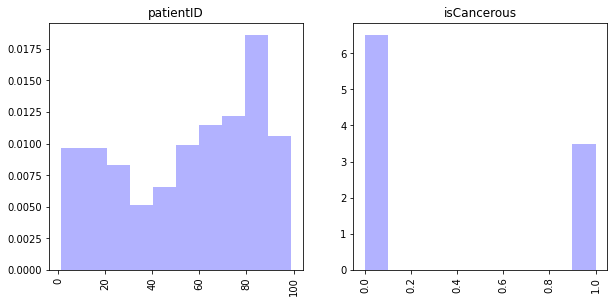

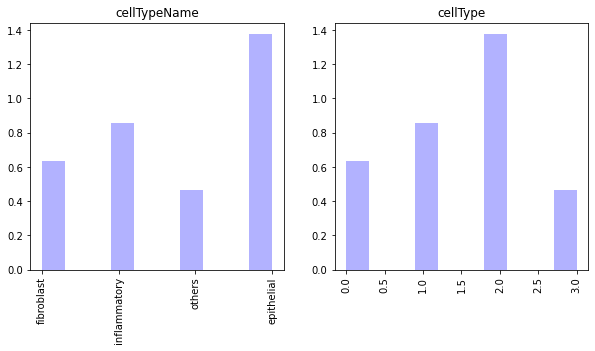

In [8]:
all_data_columns = ["patientID", "isCancerous"]
plt.figure(figsize=(10,10))
for i, col in enumerate(all_data_columns):
    plt.subplot(2,2,i+1)
    plt.hist(data[col], alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

cell_columns = ["cellTypeName", "cellType"]
plt.figure(figsize=(10,10))
for i, col in enumerate(cell_columns):
    plt.subplot(2,2,i+3)
    plt.hist(dataMain[col], alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

plt.show()

**Observations**:
* `patientID`: records from patients aren't evenly distributed - this will have to be taken into account when splitting up the data.
* `isCancerous`: is skewed, there are more instances of non-cancerous cells thant there are of cancerous cells. This will need to be considered when deciding on the performance metric and modeling. 
* `cellType`: also have varied distributions, with most cells being of the type `epithelial`

Let's take a look at the relationship between the features and the target:
`isCancerous`.

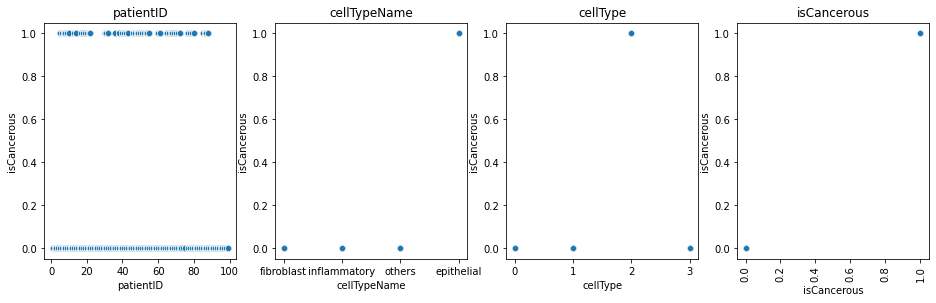

In [9]:
dist_columns = ["patientID", "cellTypeName", "cellType", "isCancerous"]
import seaborn as sns
plt.figure(figsize=(20,20))
for i, col in enumerate(dist_columns):
    plt.subplot(4,5,i+1)
    sns.scatterplot(data=data, x=col, y='isCancerous')
    plt.title(col)

plt.xticks(rotation='vertical')
plt.show()

It looks like there is a lot of patients that have cancerous cells than there are those without. Another interesting observation is with the cell type. Let's take a closer looks at the relationships between the `cellTypeName` and `isCancerous`. 

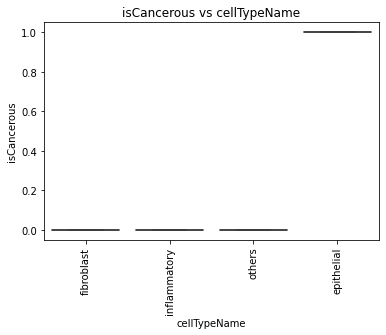

In [8]:
ax = sns.boxplot(y='isCancerous',x='cellTypeName',data=dataMain)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('isCancerous vs cellTypeName')

plt.xticks(rotation='vertical')
plt.show()

The boxplot above indicates that only the `epithelial` cells are cancerous. Let's use a different plot to investigate this further.

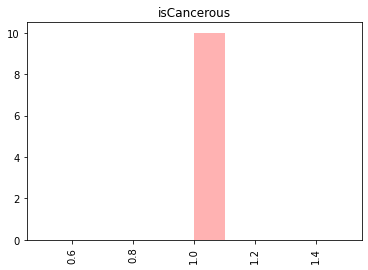

In [9]:
epithelialData = dataMain[dataMain['cellTypeName'] == 'epithelial']

plt.hist(epithelialData['isCancerous'], alpha=0.3, color='r', density=True)
plt.title(col)
plt.xticks(rotation='vertical')
plt.show()

As expected, from our previous boxplot, it looks like all cells that are labelled as `epithelial` are cancerous. We will proceed to look into the relationship between the patients and `isCancerous`.

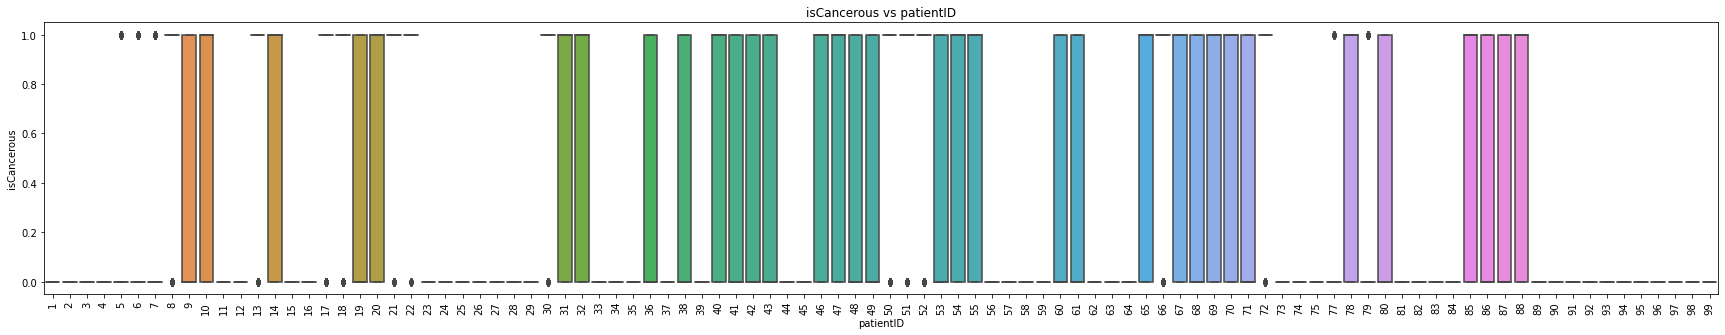

In [10]:
plt.figure(figsize=(30,5))
ax = sns.boxplot(y='isCancerous',x='patientID',data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('isCancerous vs patientID')
plt.xticks(rotation='vertical')
plt.show()

It looks like patients with cancer will have both non-cancerous and cancerous cells, as is expected since we have found that only the `epithelial` cell is cancerous.

Additionally, to ensure that the patients with different cancer statuses are distributed evenly amongst the training, validation and test sets during data splitting, the patients will be assigned randomly to each of the datasets.

Now let's view some random images from the dataset and observe it

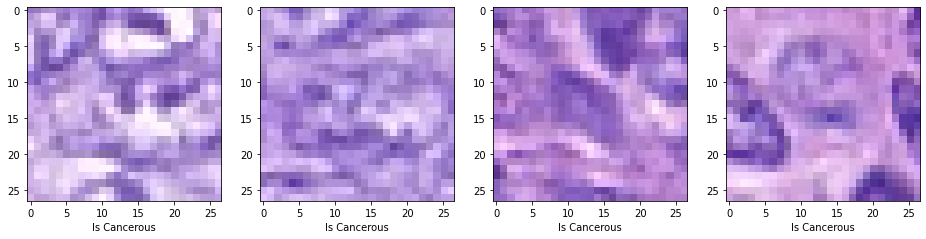

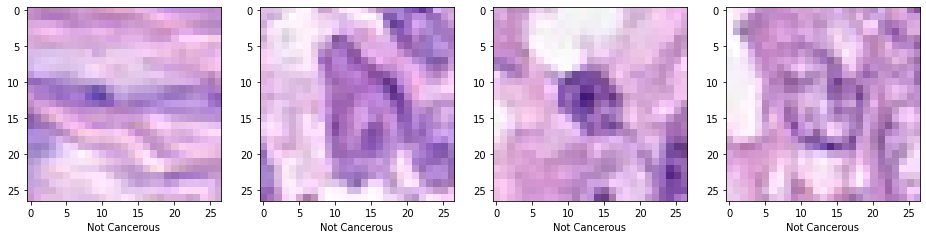

In [11]:
from PIL import Image

isCancerous_sample = data[data['isCancerous'] == 1].sample(n=4)['ImageName']

plt.figure(figsize=(16,4))
for i, ImageName in enumerate(isCancerous_sample):
    im = np.asarray(Image.open('./patch_images/' + ImageName))
    plt.subplot(1,4,i+1)
    plt.imshow(im, cmap='gray')
    plt.xlabel('Is Cancerous')
plt.show()

plt.figure(figsize=(16,4))
notCancerous_sample = data[data['isCancerous'] == 0].sample(n=4)['ImageName']
for i, ImageName in enumerate(notCancerous_sample):
    im = np.asarray(Image.open('./patch_images/' + ImageName))
    plt.subplot(1,4,i+1)
    plt.imshow(im, cmap='gray')
    plt.xlabel('Not Cancerous')
plt.show()

Just through observatoins, we can see that it's difficult to differentiate the cancerous cells from the non-cancerous cells.

# Developing Model

Let's randomly split the data for training, validation and testing. Using a 60%, 20%, 20% split, respectively. We will split the data by the pateints to ensure there is no data leakage.

In [10]:
import random
import math

upperBound = 99 
patientNum = list(range(1, upperBound))
random.shuffle(patientNum)

firstDivision = (math.ceil(upperBound*0.60))
secondDivision = firstDivision + (math.ceil(upperBound*0.20))

#Train contains 60% of the data
train_data = data[data['patientID'].isin(patientNum[:firstDivision])]

#Validation contains 20% of the data
val_data = data[data['patientID'].isin(patientNum[firstDivision:secondDivision])]

#Test contains 20% of the data
test_data = data[data['patientID'].isin(patientNum[secondDivision:upperBound])]

Let confirm that that data was split coorectly amongst the new datasets.

In [11]:
print("Train Patient Number: ", len(list(train_data['patientID'].value_counts())))
print("Val Patient Number: ", len(list(val_data['patientID'].value_counts())))
print("Test Patient Number: ", len(list(val_data['patientID'].value_counts())))

Train Patient Number:  60
Val Patient Number:  19
Test Patient Number:  19


Looks like the patients were split correctly. Let's also look at the size of each of the data sets

In [12]:
print("Train Size: ", train_data.shape[0])
print("Val Size: ", val_data.shape[0])
print("Test Size: ", test_data.shape[0])

Train Size:  12069
Val Size:  3463
Test Size:  4673


The data was split relatively close to the desired percentages we mentioned earlier, we will now proceed to check if the datasets were distributed evenly.

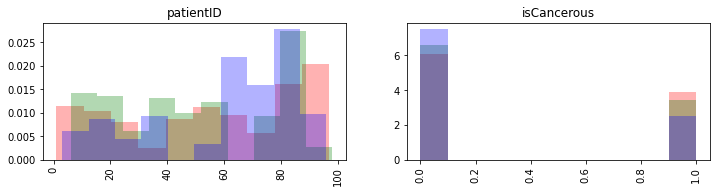

In [13]:
plt.figure(figsize=(25,60))
for i, col in enumerate(all_data_columns):
    plt.subplot(20,4,i+1)
    plt.hist(train_data[col], alpha=0.3, color='r', density=True, label='Train')
    plt.hist(val_data[col], alpha=0.3, color='g', density=True, label='Val')
    plt.hist(test_data[col], alpha=0.3, color='b', density=True, label='Test')
    plt.title(col)
    plt.xticks(rotation='vertical')

It looks like the data was distributed relatively evenly amongst the target feature.

# Baseline Model 1 - Neural Network
We will now establish a base mode for our Neural Network. We will set up a simple Multi-layer Perceptron (MLP) to begin with and incrementally improve the model to fit to our classification problem.

## Performance Metric
Since this is a classification problem, we will be using a classification metric. The recall performance metric was chosen as it is more important that the model is able to detect cancerous cells even if that involves a tradeoff of incorrectly determining healthy cells as cancerous. This is because it's vital that patients that have colon cancer are detected and are treated. Not detecting colon cancer patients poses a higher risk that flasely detecting it, as further screenings would correct any false positives that occur.

Usually for traditional Neural Network aproaches (MLP) a base target accuracy of 50% is used. Though, since our target class only contains two classes this performance would be akin to randomly selecting a class. Hence a target of 75% would be more appropriate yet realistic.

The following function will be uses to plot the learning curve of the Neural Network performance and will be used to anlyse how well the model is being trained.

In [14]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Recall'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show()

## Building Model

 We will set up the hyper parameters for the network. We wil set the hidden layer dimnestion as 256 to start with. This can later be tuned as required. The input layer corresponds to the dimensions of the image 27x27 and the three RGB values that the image is represented in. As for the output layer, this has been set to 2 to match the number of outputs we expect from the the model, those determining whether the cell is cancerous or not cancerous.

In [15]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

We will be using Sequential function to build the baseline model since we want to start off with a relatively simple model.

In [16]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

The Flatten function is used to transform the image vector into a one dimensional array of 27x27x3, which gives us 2187 points. The Dense function allows for a fully connected MLP neural layer. As for the first layer, this forms the hidden layer of the neural network. In this case, we opted to use sigmoid they are typically used when looking for a probability between 0 and 1, plus since we are only classifying between two classes sigmoid should be sufficient for now. We can look into the performance of other activation methods later. The next layer in our network forms our output layer, since we are expecting a probability between 0 and 1, the softmax activation function is used in order to normalise the output and form an overall probability of each class.

Let's looks at the summary of the model we just created.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


The model summary shows the expected output shape for each layer. We will move onto visualising this model as a figure. Make sure you have the following downloaded, otherwise you can run the command below to install them.

In [18]:
!pip install pydot
!pip install pydotplus
!pip install graphviz

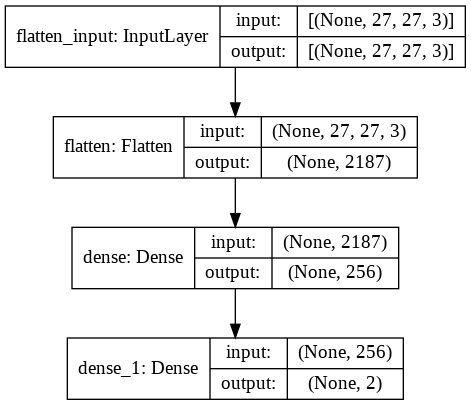

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

Now we will compile the model

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.Recall(name='recall')])

For this model, we decided to use the Adam optimization algorithm as it is both memory and computationally efficient. Additionally, it works well for problems with noisy gradients. We will explore other optimizer later to find if another optimizer fits our model better. For loss, categorical cross entropy was used as we are classifying `isCancerous` as either 0 (no) or 1 (yes). Finally, we have mentioned previously that the recall performance metric would be the most appropriate for this task and hence will be used as the metric here.

## Training Model
Now that we have established the baseline model we will move on to training the model. To begin with we will convert the `isCancerous` class into string format so it can be processed by the ImageDataGenerator.

In [21]:
train_data.loc[:,'isCancerous'] = train_data['isCancerous'].astype('str')
val_data.loc[:,'isCancerous'] = val_data['isCancerous'].astype('str')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Now that the target feature can be processed. We can use the ImageDataGenerator to load image data in batches to memory. The `flow_from_dataframe()` function will be used to load the images from the dataframe.

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='./patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 12069 validated image filenames belonging to 2 classes.
Found 3463 validated image filenames belonging to 2 classes.


We have rescaled the images from the range of 0-255 to 0-1 to make the training process faster. Additionally, the since we are doing catergorical classification, the `class_mode` as chosen to match that. As confirmation the output has identified that a number of images have been found which matches both the test and validation set size. We can now move on to training the model.

In [25]:
history = model.fit(x=train_generator, validation_data=validation_generator, epochs=100, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


Now that the model is trained, let's check the performance of the model thus far.

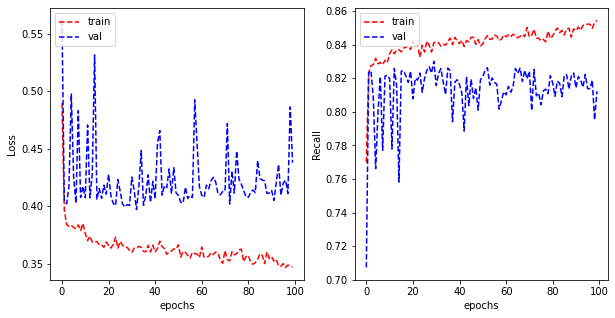

In [26]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], history.history['recall'], history.history['val_recall'], metric_name='Recall')

From this model graph we see that both the loss and recall performance oscillate quiet a bit, indicating that the model will need to be tuned. There also seems to be some overfitting occuring which will need to be fixed. Although, performance wise the results are looking promising.

## Making Incremental Changes

The oscillation occuring in the graph below may be due to not having an appropiate learning rate. By default Adam optimizer uses a learning rate of 0.001. Typically learning rate is often tuned betwen 0.001 and 0.0001, so we will try changing the learning rate to half way between these values to 0.0005 and checking the performance of that.

In [27]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.Recall(name='recall')])

history_1 = model_1.fit(x=train_generator, validation_data=validation_generator, epochs=100, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


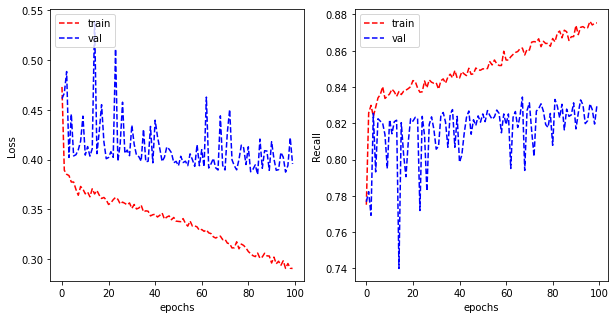

In [28]:
plot_learning_curve(history_1.history['loss'], history_1.history['val_loss'], history_1.history['recall'], history_1.history['val_recall'], metric_name='Recall')

Changing the learning rate doesn't seem to have made much of a difference to the oscillation of the validation data. Let's try using a different optimizer - RMSprop to see see if this can produce a smoother learning curve. RMSprop is known to be very robust and can can handle stochasticy in training well.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


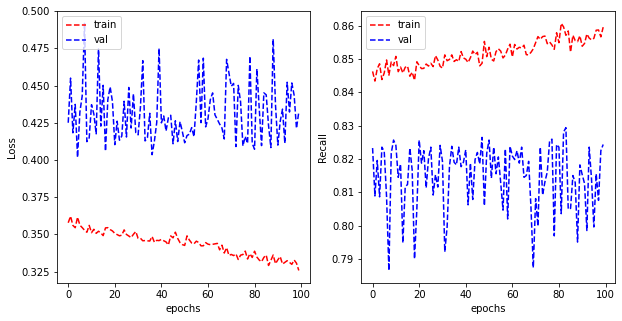

In [29]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.Recall(name='recall')])
history = model.fit(x=train_generator, validation_data=validation_generator, epochs=100, verbose=0)
plot_learning_curve(history.history['loss'], history.history['val_loss'], history.history['recall'], history.history['val_recall'], metric_name='Recall')

There doesn't seem to be any imporvement to the oscillation of the validation data. Instead, it looks like the use of RMSprop has only exasperated the issue. It may be that there is a lack of data within the validation set which is causing this oscillation.

> TODO: following uses relu instead of sigmoid

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


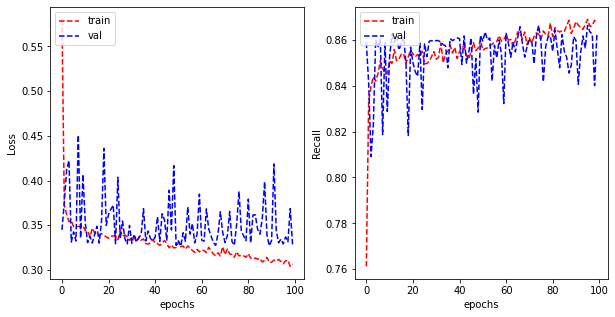

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.Recall(name='recall')])

history = model.fit(x=train_generator, validation_data=validation_generator, epochs=100, verbose=0)

plot_learning_curve(history.history['loss'], history.history['val_loss'], history.history['recall'], history.history['val_recall'], metric_name='Recall')

From the graph above we can see that dataset's performance is oscillating alot which could indicate that the learning rate needs to be tuned. By default the learning rate is 0.001, we will try decreasing this.

> Grid searching for the learning rate

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


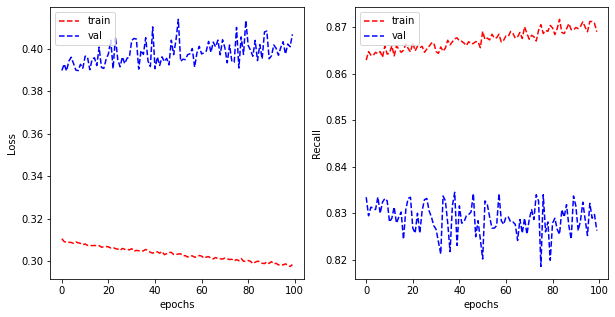

Train recall for lr = 0.0001 :  [0.8629290461540222, 0.8647597432136536, 0.8639969229698181, 0.8639206886291504, 0.8646071553230286, 0.8643020391464233, 0.8647597432136536, 0.8635392785072327, 0.8659801483154297, 0.8642258048057556, 0.8644546270370483, 0.8659801483154297, 0.8638443946838379, 0.8659801483154297, 0.8652936816215515, 0.8646071553230286, 0.8650648593902588, 0.8664378523826599, 0.8654462099075317, 0.8646834492683411, 0.8666666746139526, 0.8649122714996338, 0.865903913974762, 0.8655987977981567, 0.865903913974762, 0.8646071553230286, 0.8652936816215515, 0.865903913974762, 0.8665903806686401, 0.8666666746139526, 0.8647597432136536, 0.8643783330917358, 0.865751326084137, 0.8648359775543213, 0.8655225038528442, 0.8672006130218506, 0.8662090301513672, 0.8668954968452454, 0.8675057291984558, 0.8677345514297485, 0.8670480251312256, 0.8669717907905579, 0.8665903806686401, 0.8660564422607422, 0.8668954968452454, 0.8664378523826599, 0.8665140867233276, 0.8668954968452454, 0.866895496

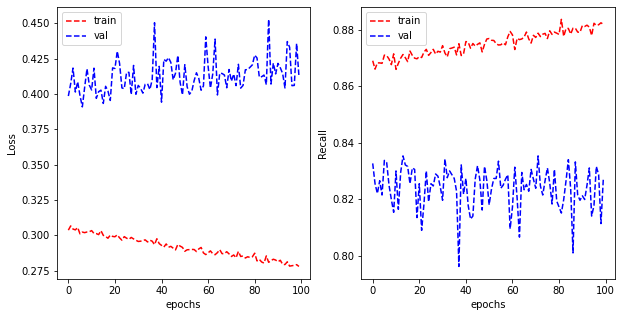

Train recall for lr = 0.00039999999999999996 :  [0.8689550161361694, 0.8659801483154297, 0.868192195892334, 0.868192195892334, 0.8680396676063538, 0.870938241481781, 0.870785653591156, 0.8695651888847351, 0.8675820231437683, 0.8713958859443665, 0.865903913974762, 0.8680396676063538, 0.8698703050613403, 0.8711670637130737, 0.8700228929519653, 0.8686498999595642, 0.8723874688148499, 0.8708619475364685, 0.8698703050613403, 0.8696414828300476, 0.8704042434692383, 0.8700991868972778, 0.8720061182975769, 0.8729977011680603, 0.8708619475364685, 0.8718535304069519, 0.8729977011680603, 0.871319591999054, 0.8723112344741821, 0.8720061182975769, 0.8742944598197937, 0.8717010021209717, 0.8703280091285706, 0.873226523399353, 0.8734554052352905, 0.873760461807251, 0.8710144758224487, 0.8749809265136719, 0.870785653591156, 0.8713958859443665, 0.8757436871528625, 0.8755148649215698, 0.873379111289978, 0.8750572204589844, 0.8741418719291687, 0.8747521042823792, 0.8752860426902771, 0.8720823526382446, 0

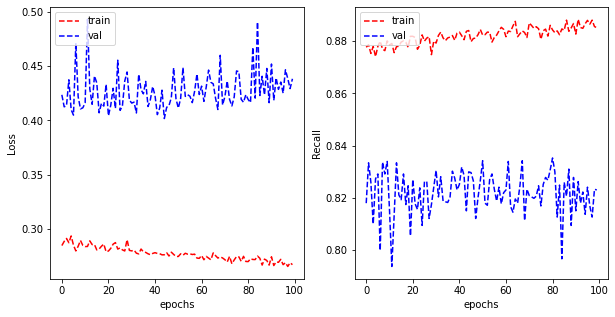

Train recall for lr = 0.0007 :  [0.8776506781578064, 0.8786422610282898, 0.8752860426902771, 0.8779557347297668, 0.8740655779838562, 0.8780320286750793, 0.8799389600753784, 0.8769641518592834, 0.876353919506073, 0.8800915479660034, 0.8784896731376648, 0.8790999054908752, 0.8755911588668823, 0.8778795003890991, 0.8780320286750793, 0.8796338438987732, 0.8800915479660034, 0.8795576095581055, 0.8776506781578064, 0.8818458914756775, 0.8818458914756775, 0.881388247013092, 0.876887857913971, 0.8784134387969971, 0.8823798894882202, 0.8800152540206909, 0.8811594247817993, 0.8816933631896973, 0.8748283982276917, 0.8800152540206909, 0.8792524933815002, 0.8821510076522827, 0.8834477663040161, 0.8812357187271118, 0.8801677823066711, 0.8812357187271118, 0.881540834903717, 0.8821510076522827, 0.8803203701972961, 0.8830663561820984, 0.8834477663040161, 0.882074773311615, 0.8805491924285889, 0.8837528824806213, 0.8840579986572266, 0.8797864317893982, 0.8810068368911743, 0.8811594247817993, 0.8824561238

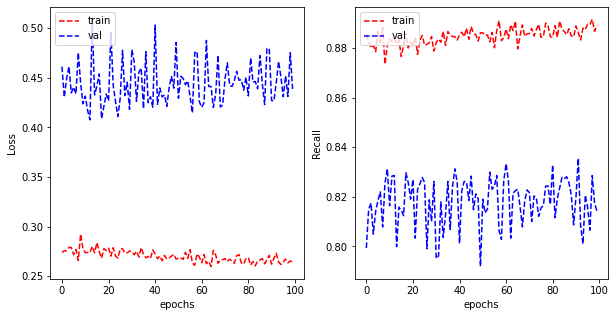

Train recall for lr = 0.001 :  [0.8855835199356079, 0.8828375339508057, 0.8800915479660034, 0.8810831308364868, 0.8785659670829773, 0.886956512928009, 0.8821510076522827, 0.8884057998657227, 0.8734554052352905, 0.8812357187271118, 0.8836765885353088, 0.8824561238288879, 0.8838291168212891, 0.8817696571350098, 0.8832951784133911, 0.8765827417373657, 0.8812357187271118, 0.8860411643981934, 0.8800915479660034, 0.8826087117195129, 0.8809306025505066, 0.8844393491744995, 0.8774980902671814, 0.8831426501274109, 0.8851258754730225, 0.8811594247817993, 0.881540834903717, 0.8821510076522827, 0.8846681714057922, 0.87879478931427, 0.8823035955429077, 0.8836002945899963, 0.8823798894882202, 0.8867276906967163, 0.8810831308364868, 0.8867276906967163, 0.8852021098136902, 0.8846681714057922, 0.8846681714057922, 0.8832189440727234, 0.8853546977043152, 0.8864225745201111, 0.8845919370651245, 0.8880243897438049, 0.8836002945899963, 0.8887109160423279, 0.8859649300575256, 0.8854309916496277, 0.8828375339

In [31]:
lr_param = np.linspace(0.0001, 0.001, 4)

#Search
train_performance = list()
valid_performance = list()

for lr in lr_param:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=[tf.keras.metrics.Recall(name='recall')])
    history = model.fit(x=train_generator, validation_data=validation_generator, epochs=100, verbose=0)
    
    plot_learning_curve(history.history['loss'], history.history['val_loss'], history.history['recall'], history.history['val_recall'], metric_name='Recall')
    
    train_performance.append(history.history['recall'])
    valid_performance.append(history.history['val_recall'])
    print("Train recall for lr =",  lr, ": ", history.history['recall'])
    print("Val recall for lr = ", lr, ": ", history.history['val_recall'])

## Data Augmentation

Found 12069 validated image filenames belonging to 2 classes.
Found 3463 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


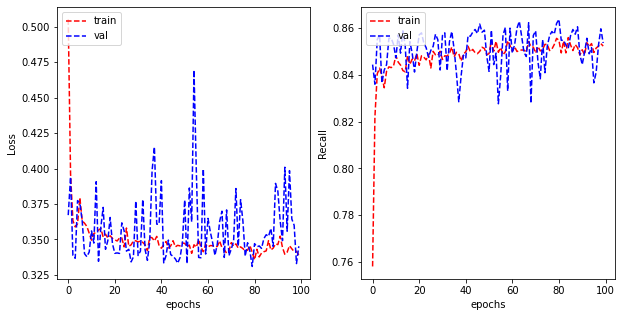

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='./patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

##Add model after determining best optimization tchnique and learning rate....

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.Recall(name='recall')])

history = model.fit(x=train_generator, validation_data=validation_generator, epochs=100, verbose=0)

plot_learning_curve(history.history['loss'], history.history['val_loss'], history.history['recall'], history.history['val_recall'], metric_name='Recall')

## Evaluating Model
Now we will test the final model

In [25]:
test_data.loc[:,'isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='./patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27,27),
    batch_size=batch_size,
    class_mode='categorical')

Found 4673 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [26]:
model.evaluate(test_generator)

4673/4673 [==============================] - 9s 2ms/step - loss: 0.6527 - recall: 0.7319


[0.6527038812637329, 0.7318639159202576]

From our model we were able to achieve a recall performance of 0.7319 which is about where we had expected the model to perform. On the other hand the loss was 0.6527 which is much higher than should be acceptable

# Base Model 2 - Deep Learning 

At the moment Deep Learning models are very popular for image classification. We will investigate the use of Convolutional Neural Network (CNN) model. As opposed to the MLP model, the CNN model will involve many convolution layers which will aid in finding more abtract features in the image which should help with our classification task.

## Performance Metric
We will keep the performnace metric the same - recall. Asn mentioned before recall is the best fit for what we aim to achieve in this task and doing so will also ensure that both models can be compared. Typically for CNN models a 70% accuracy seems to be realistic. Though, since we are only classifying between two classes and our MLP model also produced promising results, we will aim for an 80% recall probability. The learning curve defined in the first baseline model can also be used here, and will be used to determine how well the model is training.

## Building Model
we will start by using a fairly simple network architecture - VGG as our baseline model as it should be suffcient for our simple task. The VGG neural network was originally adapted to classify larger images, since our images are relatively small we will reduce the model's complexity to using only two convolution layers with maxpooling and a total of three blocks to start off with.

In [ ]:
import tensorflow as tf
model_VGG = tf.keras.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #Block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #Block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

**Observations:**
* Using 3 by 3 convolution kernels
* Always using max-pooling - which is (2 by 2) - this is popular option 
* Max pooling used to reduce size of features (lower dimensionality)
* Used relu activation function
* Padding is same - retained border pixels when applying convolutions - since images are small each pixel counts

Now we will compile and fit the model

In [ ]:
model_VGG.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.Recall(name='recall')])

In [ ]:
#Resetting to regular images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='./patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 11783 validated image filenames belonging to 2 classes.
Found 4227 validated image filenames belonging to 2 classes.


In [ ]:
# history_VGG = model_VGG.fit_generator(train_generator, validation_data=validation_generator, epochs=100, verbose=0)
history_VGG = model_VGG.fit(x=train_generator, validation_data=validation_generator, epochs=100, verbose=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


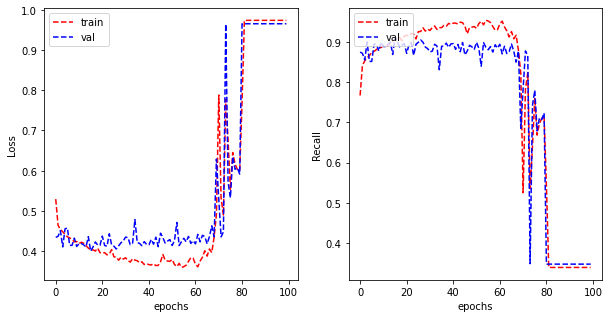

In [ ]:
plot_learning_curve(history_VGG.history['loss'], history_VGG.history['val_loss'], 
                    history_VGG.history['recall'], history_VGG.history['val_recall'], 
                    metric_name='Recall')

**Observations:**
* may need to tune learning rate, this may be the result of the learning rate being too high as wwe can see higher and higher levels of oscillation also occuring 

> Using sigmoid activation function in hopes of improving performance

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


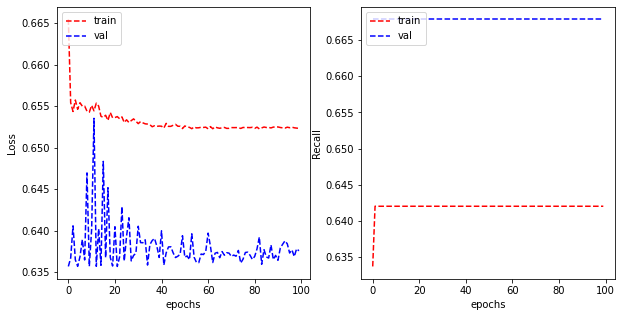

In [ ]:
import tensorflow as tf
model_VGG = tf.keras.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #Block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #Block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

model_VGG.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.Recall(name='recall')])
history_VGG = model_VGG.fit(x=train_generator, validation_data=validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG.history['loss'], history_VGG.history['val_loss'], 
                    history_VGG.history['recall'], history_VGG.history['val_recall'], 
                    metric_name='Recall')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


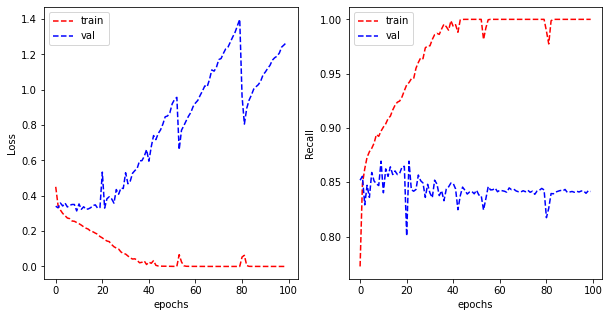

In [ ]:
#decreasing learning rate
import tensorflow as tf
model_VGG = tf.keras.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #Block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #Block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

model_VGG.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.Recall(name='recall')])
history_VGG = model_VGG.fit(x=train_generator, validation_data=validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG.history['loss'], history_VGG.history['val_loss'], 
                    history_VGG.history['recall'], history_VGG.history['val_recall'], 
                    metric_name='Recall')

**Obsevations:**
* High level of overfitting is occuring 

## Making Incremental Changes
>TODO: Complete

Based on the observations made from the base model...


We'll start by applying some weight regularization and dropout.

In [ ]:
#adding Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='./patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 11783 validated image filenames belonging to 2 classes.
Found 4227 validated image filenames belonging to 2 classes.


In [ ]:
reg_lambda = 0.001

model_VGG = tf.keras.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #Block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #Block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

model_VGG.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.Recall(name='recall')])

history_VGG = model_VGG.fit(x=train_generator, validation_data=validation_generator, epochs=100, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


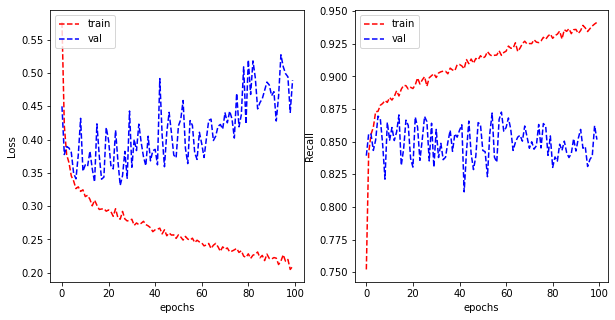

In [ ]:
plot_learning_curve(history_VGG.history['loss'], history_VGG.history['val_loss'], 
                    history_VGG.history['recall'], history_VGG.history['val_recall'], 
                    metric_name='Recall')

## Evaluating Model
Now we will test the final model

In [ ]:
test_data.loc[:,'isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='./patch_images',
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(27,27),
    batch_size=batch_size,
    class_mode='categorical')

In [ ]:
model.evaluate(test_generator)

The model was able to achieve...

# Model Comparison and Final Judgement

## Biases
We tried to remove any biases or data leakages that could occur from the multiple records present from any single patient by splitting the data based on the patients.

## Analysis of Final NN Model
The following visualizes the results.

In [27]:
label_names = {'isCancerous': 0, 'notCancerous': 1}

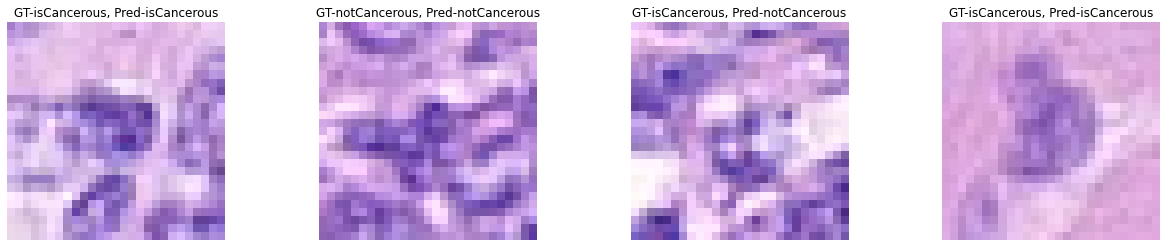

In [29]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(27,4))
batches = 0
for x,y in test_generator:
    batches = batches + 1
    y_hat = model.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches < 5:
        plt.subplot(1,5,batches)
        plt.imshow(x)
        plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
    else:
        break
    plt.axis('off')

## Analysis of Final DL Model
The following visualizes the results.